In [11]:
import pandas as pd
import pickle as pkl
import shap
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [12]:
rf_results = pd.read_csv('../_data/full_data_with_predictions_rf.csv')
gbm_results = pd.read_csv('../_data/full_data_with_predictions_gbm.csv')
xgb_results = pd.read_csv('../_data/full_data_with_predictions_xgboost.csv')

In [13]:
# Best model is GBM
print(f'RMSE for Random Forest: {mean_squared_error(rf_results.percent_vaccinated_log, rf_results.prediction, squared=True)}')
print(f'RMSE for GBM: {mean_squared_error(gbm_results.percent_vaccinated_log, gbm_results.prediction, squared=True)}')
print(f'RMSE for XGBoost: {mean_squared_error(xgb_results.percent_vaccinated_log, xgb_results.prediction, squared=True)}')

RMSE for Random Forest: 0.02024194670611329
RMSE for GBM: 0.01897206394186399
RMSE for XGBoost: 0.022079091528842267


In [14]:
# Analyze results only for the best model
with open('../_data/model_gbm.pkl', 'rb') as f:
    gbm_model = pkl.load(f)

Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator DummyRegressor from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GradientBoostingRegressor from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [15]:
# Add information about the type of municipality to the data frame (1 = urban, 2 = rural, 3 = mixed urban-rural)
# def muncipality_type_conditional(x):
#     if x == '1':
#         return 'urban'
#     elif x == '2':
#         return 'rural'
#     else:
#         return 'mixed_urban_rural'

# gbm_results['municipality_type'] = gbm_results['municipality_code'].map(lambda x: muncipality_type_conditional(str(x)[-1]))

## Feature importance-related XAI plots

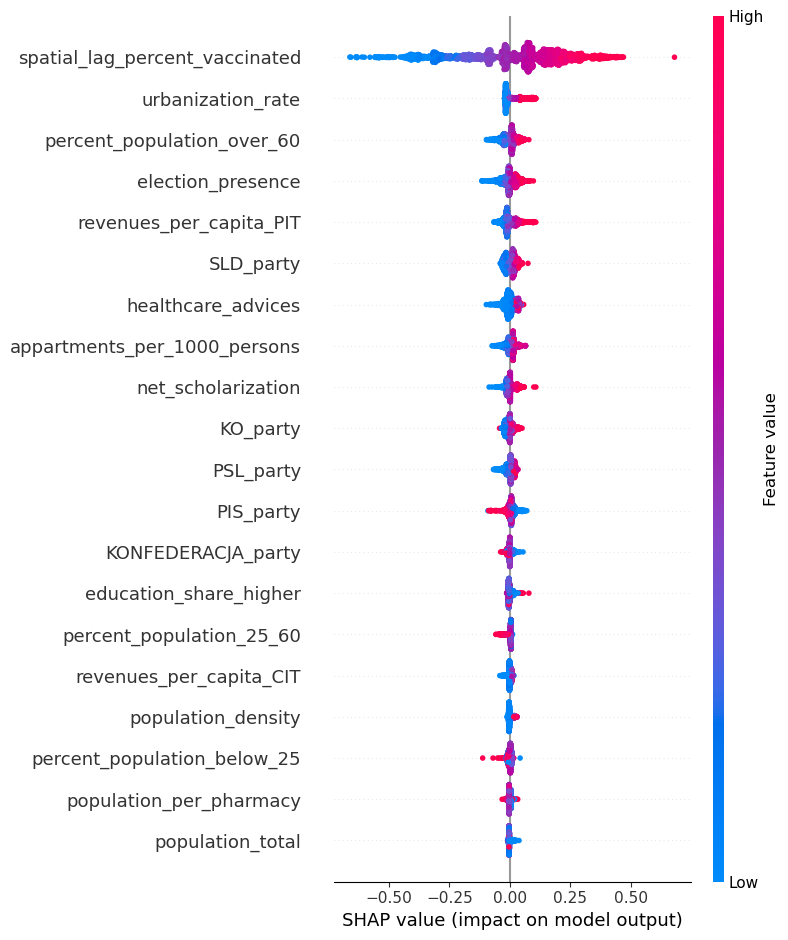

In [20]:
# Create object that can calculate shap values
explainer_tree = shap.TreeExplainer(gbm_model)

filtered_df = gbm_results.drop(columns=['percent_vaccinated_log', 'prediction'])
shap_values1 = explainer_tree.shap_values(filtered_df)

shap.summary_plot(shap_values1, filtered_df)

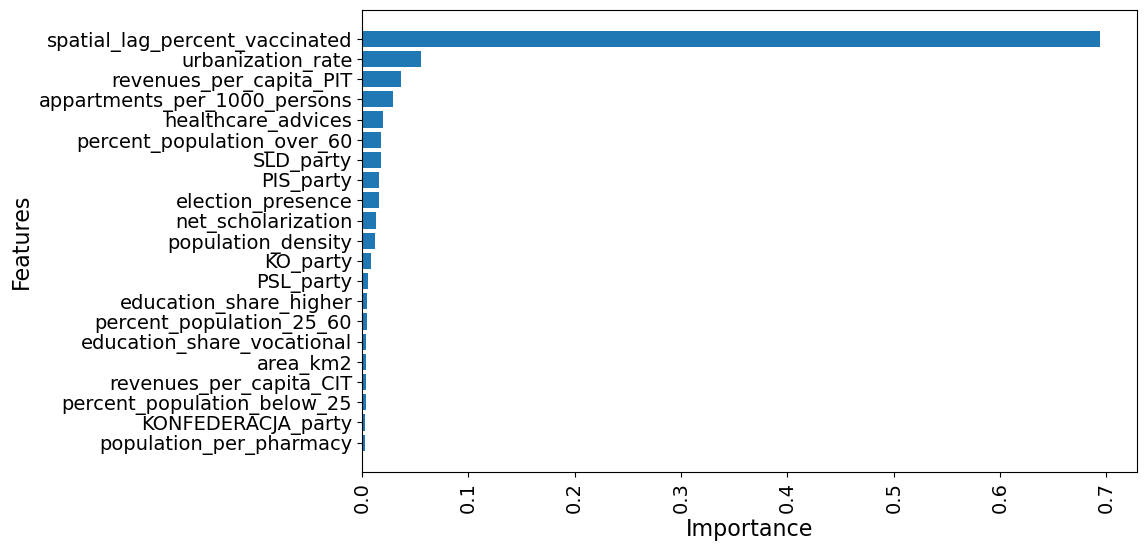

In [53]:
# Impurity based

# Get feature importances from the trained model
feature_importances = gbm_model.feature_importances_

# Get the names of the features
feature_names = gbm_model.feature_names_in_  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True).reset_index(drop=True)

# Create a barplot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][20:], feature_importance_df['Importance'][20:])
# Set the font size for the axis labels and tick marks
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.show()

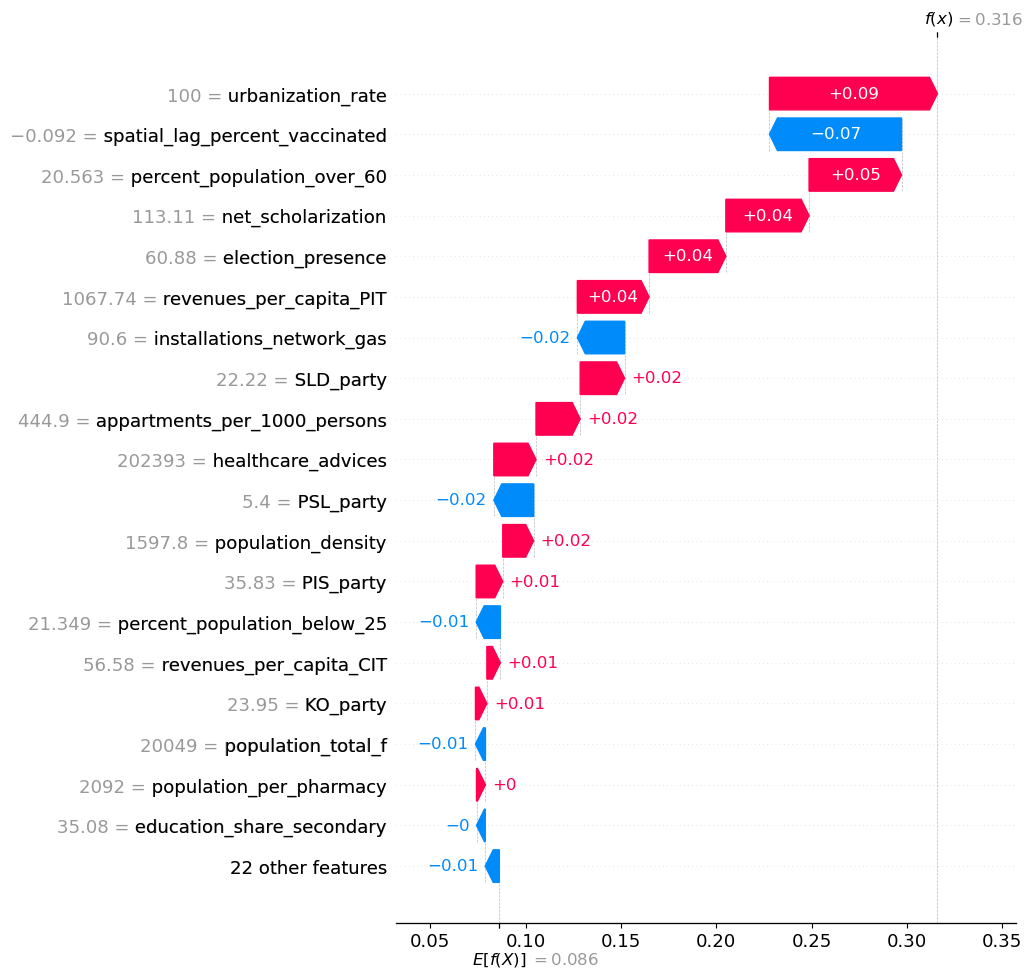

In [21]:
explainer = shap.Explainer(gbm_model, filtered_df)
shap_values2 = explainer(filtered_df, check_additivity=False)
shap.plots.waterfall(shap_values2[0], max_display=20)

## XAI plot for big city vs. rural hypothesis

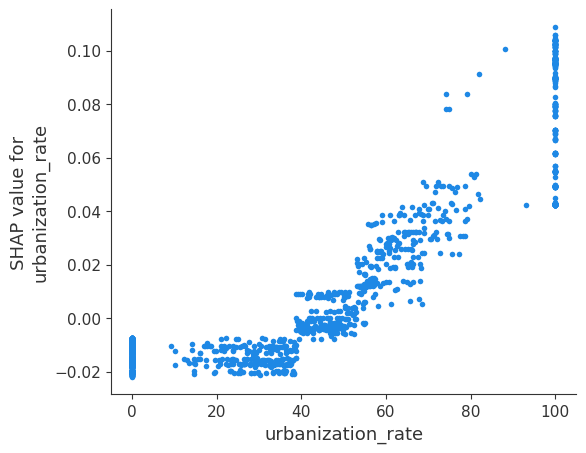

In [22]:
shap.dependence_plot("urbanization_rate", shap_values1, filtered_df, interaction_index=None)

## XAI plots for Age related hypothesis

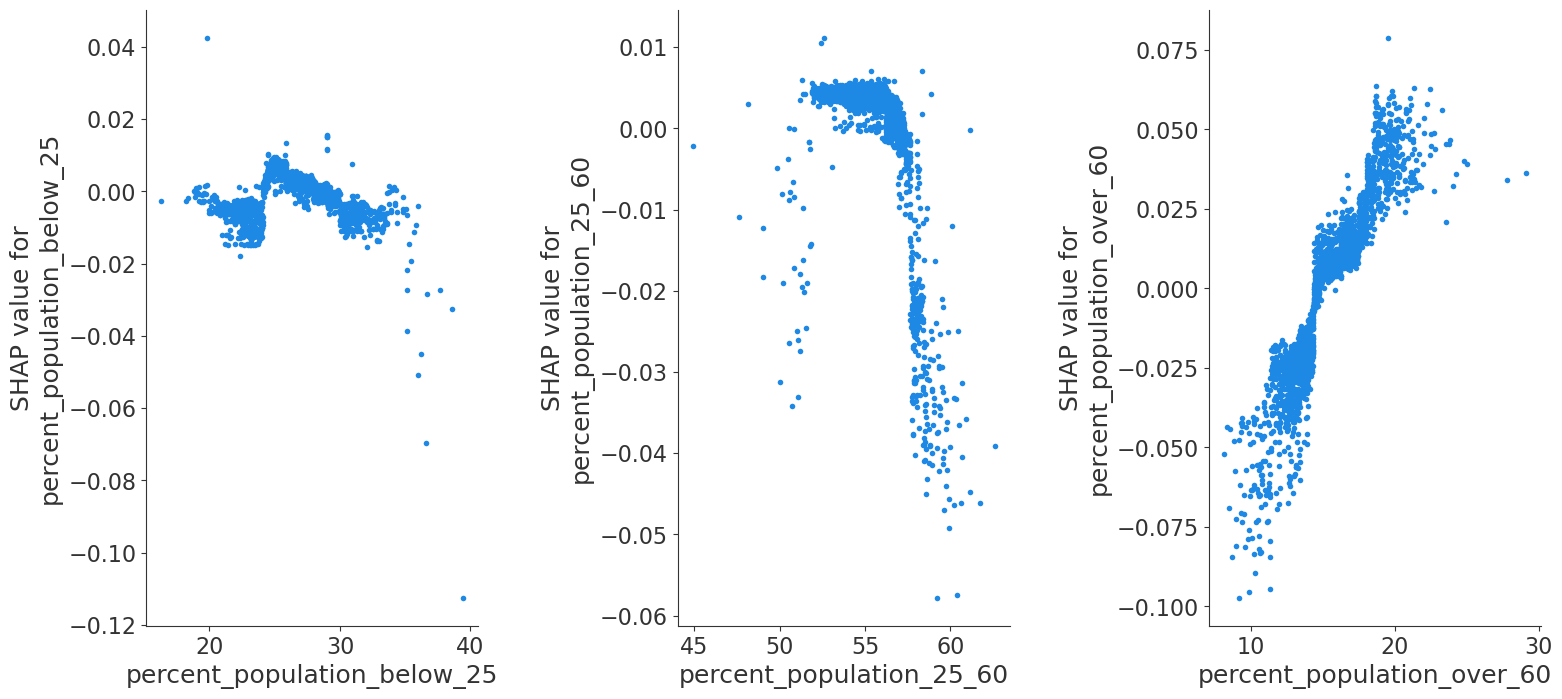

In [39]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 8))

# Plot the dependence plots
shap.dependence_plot("percent_population_below_25", shap_values1, filtered_df, interaction_index=None, ax=axs[0], show=False)
shap.dependence_plot("percent_population_25_60", shap_values1, filtered_df, interaction_index=None, ax=axs[1], show=False)
shap.dependence_plot("percent_population_over_60", shap_values1, filtered_df, interaction_index=None, ax=axs[2], show=False)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.6)

# Increase font size for labels and tick marks
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

# Show the plots
plt.show()

## Potential XAI plot for dependence with additional feature on the y-axis

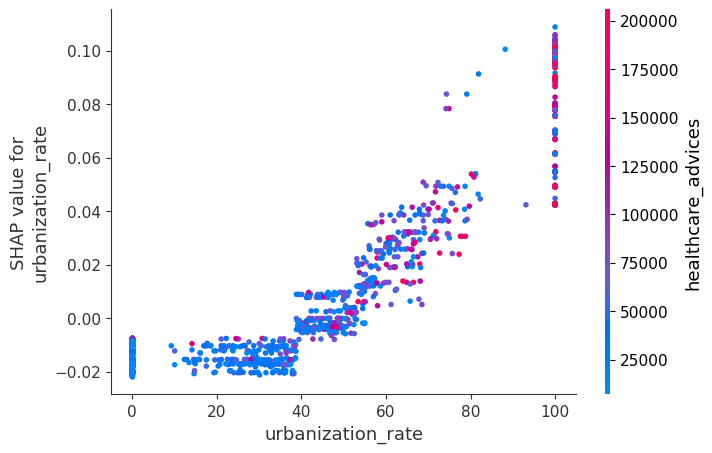

In [26]:
shap.dependence_plot("urbanization_rate", shap_values1, filtered_df, interaction_index="healthcare_advices")